# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# One more import after logging in

from items import Item

In [9]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [10]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [11]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

HP PAPER, LF HEAVYWEIGHT COATED, 54
HP Heavyweight Coated Paper 54 x 100' 35lb 90 GE/101 ISO (D65) Brightness 1 / Roll Premium, 35 lb., 130 gsm, bright white coated paper For color accurate working comps and design proofs, fine line drawings and illustrations Produces rich color that is consistent from roll to roll Enhanced coating adds abrasion resistance to this easy to handle paper Prints can be rolled or stacked immediately off the printer Manufacturer Hewlett-Packard, Brand HP, Weight 14.55 pounds, Dimensions 5 x 5 x 5 inches, model number Is Discontinued No, Color White, Paper Weight 35, Paper Finish Coated, Glossy, Manufacturer Part Available March 

Price is $234.00


In [12]:
# Remind a test prompt

print(train[0].price)

233.69


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [13]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [14]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $385.97 Error: $269.03 SLE: 0.28 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $115.00 Truth: $277.91 Error: $162.91 SLE: 0.77 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $26.00 Truth: $147.33 Error: $121.33 SLE: 2.90 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $760.00 Truth: $74.99 Error: $685.01 SLE: 5.31 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $282.00 Truth: $19.99 Error: $262.01 SLE: 6.77 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $251.00 Truth: $166.60 Error: $84.40 SLE: 0.17 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $229.00 Truth: $265.00 Error: $36.00 SLE: 0.02 Item: Nest Cam IQ, Works with Alexa
8: Guess: $143.00 Truth: $165.99 Error: $22.99 SLE: 0.02 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $755.00 Truth: $69.99 Error: $685.01 SLE: 5.60 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $105.00 Truth: $319.59 Error: $214.59 

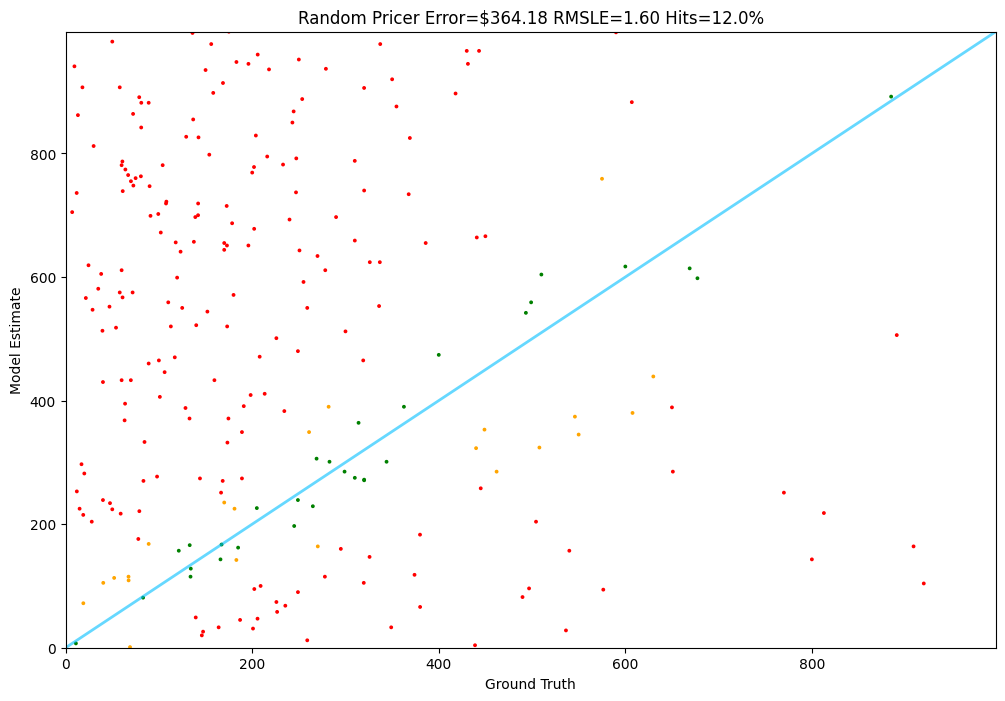

In [15]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [16]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.17 Truth: $385.97 Error: $165.80 SLE: 0.31 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $220.17 Truth: $277.91 Error: $57.74 SLE: 0.05 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $220.17 Truth: $147.33 Error: $72.84 SLE: 0.16 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $220.17 Truth: $74.99 Error: $145.18 SLE: 1.14 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $220.17 Truth: $19.99 Error: $200.18 SLE: 5.55 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $220.17 Truth: $166.60 Error: $53.57 SLE: 0.08 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $220.17 Truth: $265.00 Error: $44.83 SLE: 0.03 Item: Nest Cam IQ, Works with Alexa
8: Guess: $220.17 Truth: $165.99 Error: $54.18 SLE: 0.08 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $220.17 Truth: $69.99 Error: $150.18 SLE: 1.29 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $220.17 Truth: $319.59 Error: $99.42 SL

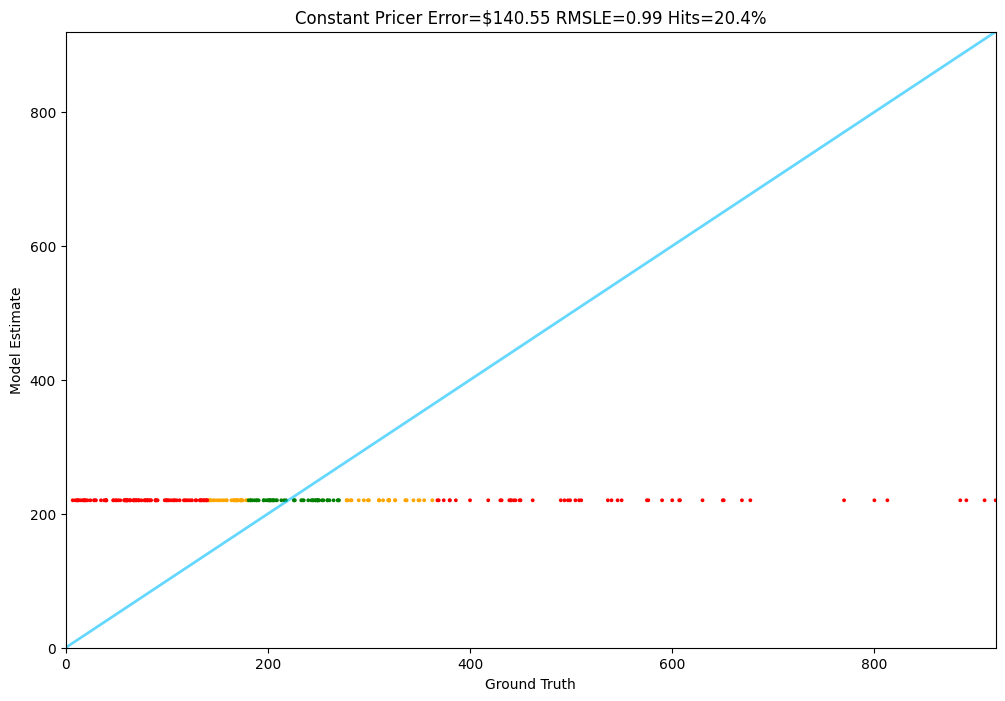

In [17]:
# Run our constant predictor
Tester.test(constant_pricer)


In [18]:
train[0].details

'{"Manufacturer": "Hewlett-Packard", "Brand": "HP", "Item Weight": "14.55 pounds", "Package Dimensions": "5 x 5 x 5 inches", "Item model number": "C6570C", "Is Discontinued By Manufacturer": "No", "Color": "White", "Paper Weight": "35", "Paper Finish": "Coated, Glossy", "Manufacturer Part Number": "C6570C", "Date First Available": "March 13, 2012"}'

In [19]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [20]:
train[0].features.keys()

dict_keys(['Manufacturer', 'Brand', 'Item Weight', 'Package Dimensions', 'Item model number', 'Is Discontinued By Manufacturer', 'Color', 'Paper Weight', 'Paper Finish', 'Manufacturer Part Number', 'Date First Available'])

In [21]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360195),
 ('Item Weight', 350726),
 ('Manufacturer', 349424),
 ('Brand', 340532),
 ('Best Sellers Rank', 330963),
 ('Item model number', 277332),
 ('Product Dimensions', 262614),
 ('Color', 184127),
 ('Is Discontinued By Manufacturer', 169490),
 ('Manufacturer Part Number', 145008),
 ('Material', 137762),
 ('Country of Origin', 121767),
 ('Style', 77859),
 ('Special Feature', 74882),
 ('Part Number', 74602),
 ('Batteries Required?', 73938),
 ('Package Dimensions', 73199),
 ('Item Dimensions LxWxH', 71156),
 ('Included Components', 67628),
 ('Model', 65072),
 ('Size', 58375),
 ('Item Package Quantity', 58232),
 ('Batteries Included?', 57002),
 ('OEM Part Number', 56148),
 ('Special Features', 54147),
 ('Exterior', 50648),
 ('Power Source', 50419),
 ('Vehicle Service Type', 49469),
 ('Finish Type', 46280),
 ('Voltage', 46089),
 ('Mounting Type', 37951),
 ('Model Name', 37390),
 ('Shape', 35159),
 ('Number of Items', 32145),
 ('Finish', 32025),
 ('Connectivity Te

In [22]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [23]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

4.75 Tons


In [24]:
average_weight = sum(weights)/len(weights)
average_weight

13.575618809133857

In [25]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [26]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [27]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380280.14010806195

In [28]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [29]:
def get_text_length(item):
    return len(item.test_prompt())

In [30]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5533),
 ('Power Stop', 3651),
 ('Dell', 3276),
 ('Detroit Axle', 2709),
 ('Lenovo', 2416),
 ('Dorman', 2131),
 ('SAMSUNG', 1769),
 ('BUYAUTOPARTS!', 1717),
 ('ACDelco', 1631),
 ('Evan Fischer', 1425),
 ('ASUS', 1400),
 ('Sony', 1288),
 ('Canon', 1216),
 ('Kohler', 1152),
 ('Callahan BRAKE PARTS', 1151),
 ('CURT', 1119),
 ('R1 Concepts', 1049),
 ('Rareelectrical', 1027),
 ('Coverking', 934),
 ('Garage-Pro', 907),
 ('Kingston Brass', 850),
 ('Moen', 833),
 ('Auto Dynasty', 830),
 ('Spectra Premium', 818),
 ('DELTA FAUCET', 807),
 ('Cardone', 801),
 ('WeatherTech', 800),
 ('Apple', 781),
 ('K&N', 762),
 ('Generic', 758),
 ('APS', 757),
 ('EBC Brakes', 736),
 ('Walker', 733),
 ('GM', 730),
 ('AKKON', 641),
 ('A-Premium', 639),
 ('TYC', 637),
 ('SPEC-D TUNING', 627),
 ('DB Electrical', 617),
 ('ECCPP', 609)]

In [31]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [32]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [33]:
# Look at features in a training item
get_features(train[0])

{'weight': 14.55,
 'rank': 380280.14010806195,
 'text_length': 724,
 'is_top_electronics_brand': 1}

In [34]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

4.75 Tons


In [35]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2690067257043753
rank: 5.144794464716764e-05
text_length: 0.0032993248125854986
is_top_electronics_brand: 197.78982311320138
Intercept: 185.2986248047016
Mean Squared Error: 34631.40350471091
R-squared Score: 0.02098270664371138


In [36]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $223.18 Truth: $385.97 Error: $162.79 SLE: 0.30 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $194.31 Truth: $277.91 Error: $83.60 SLE: 0.13 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $234.00 Truth: $147.33 Error: $86.67 SLE: 0.21 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $278.19 Truth: $74.99 Error: $203.20 SLE: 1.69 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $193.46 Truth: $19.99 Error: $173.47 SLE: 4.96 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $209.35 Truth: $166.60 Error: $42.75 SLE: 0.05 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $194.85 Truth: $265.00 Error: $70.15 SLE: 0.09 Item: Nest Cam IQ, Works with Alexa
8: Guess: $211.80 Truth: $165.99 Error: $45.81 SLE: 0.06 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $206.55 Truth: $69.99 Error: $136.56 SLE: 1.15 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $213.29 Truth: $319.59 Error: $106.30 S

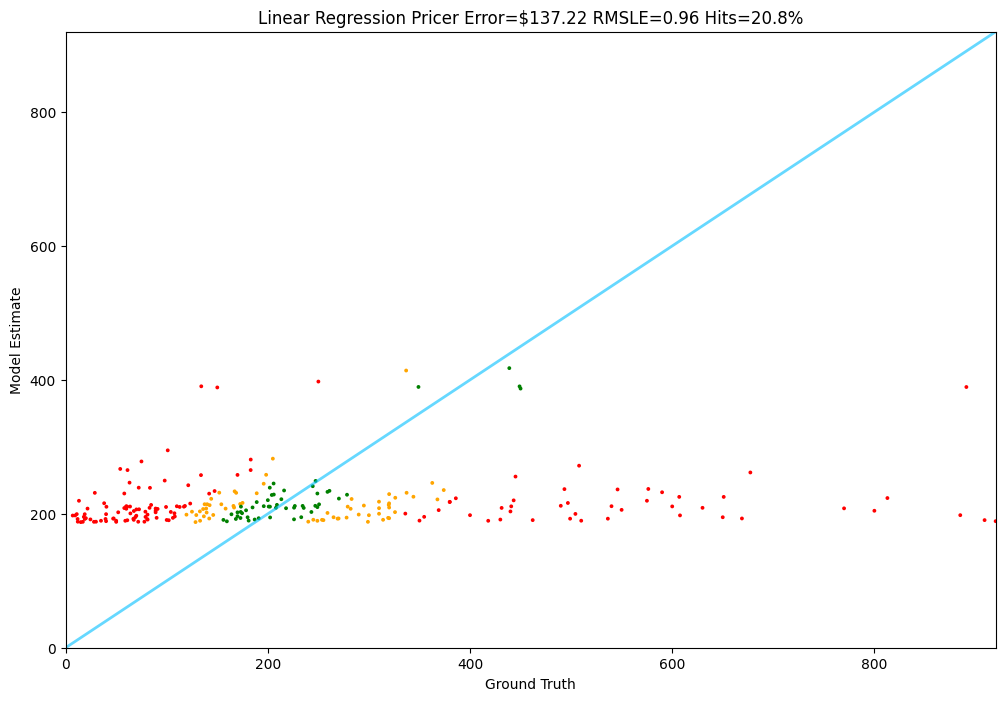

In [37]:
# test it

Tester.test(linear_regression_pricer)

In [38]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [39]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [40]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $312.70 Truth: $385.97 Error: $73.27 SLE: 0.04 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $225.81 Truth: $277.91 Error: $52.10 SLE: 0.04 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $195.15 Truth: $147.33 Error: $47.82 SLE: 0.08 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $95.23 Truth: $74.99 Error: $20.24 SLE: 0.06 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $147.28 Truth: $19.99 Error: $127.29 SLE: 3.82 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $159.90 Truth: $166.60 Error: $6.70 SLE: 0.00 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $239.34 Truth: $265.00 Error: $25.66 SLE: 0.01 Item: Nest Cam IQ, Works with Alexa
8: Guess: $216.62 Truth: $165.99 Error: $50.63 SLE: 0.07 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $86.19 Truth: $69.99 Error: $16.20 SLE: 0.04 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $241.06 Truth: $319.59 Error: $78.53 SLE: 0.0

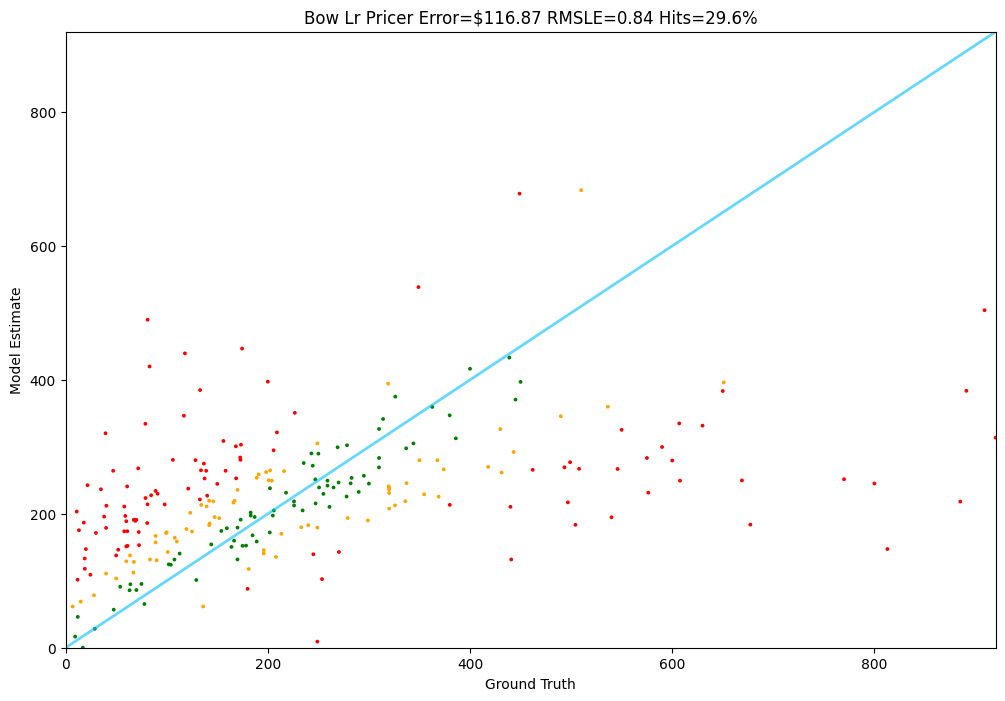

In [41]:
# test it

Tester.test(bow_lr_pricer)

In [42]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [43]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [44]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [45]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $325.01 Truth: $385.97 Error: $60.96 SLE: 0.03 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $253.90 Truth: $277.91 Error: $24.01 SLE: 0.01 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $160.01 Truth: $147.33 Error: $12.68 SLE: 0.01 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $121.86 Truth: $74.99 Error: $46.87 SLE: 0.23 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $101.29 Truth: $19.99 Error: $81.30 SLE: 2.51 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $252.98 Truth: $166.60 Error: $86.38 SLE: 0.17 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $283.97 Truth: $265.00 Error: $18.97 SLE: 0.00 Item: Nest Cam IQ, Works with Alexa
8: Guess: $241.95 Truth: $165.99 Error: $75.96 SLE: 0.14 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $100.41 Truth: $69.99 Error: $30.42 SLE: 0.13 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $265.38 Truth: $319.59 Error: $54.21 SLE: 0

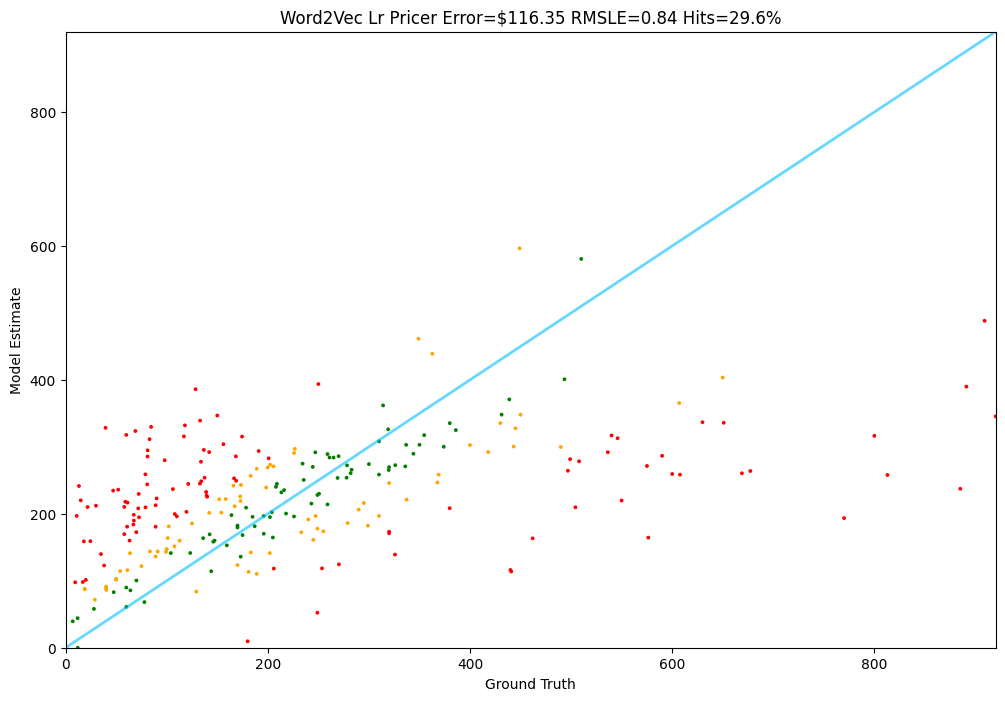

In [46]:
Tester.test(word2vec_lr_pricer)

In [47]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [48]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $240.97 Truth: $385.97 Error: $145.00 SLE: 0.22 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $197.42 Truth: $277.91 Error: $80.49 SLE: 0.12 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $121.70 Truth: $147.33 Error: $25.63 SLE: 0.04 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $124.01 Truth: $74.99 Error: $49.02 SLE: 0.25 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $74.51 Truth: $19.99 Error: $54.52 SLE: 1.64 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $223.35 Truth: $166.60 Error: $56.75 SLE: 0.09 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $209.29 Truth: $265.00 Error: $55.71 SLE: 0.06 Item: Nest Cam IQ, Works with Alexa
8: Guess: $190.00 Truth: $165.99 Error: $24.01 SLE: 0.02 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $98.82 Truth: $69.99 Error: $28.83 SLE: 0.12 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $220.07 Truth: $319.59 Error: $99.52 SLE: 0.

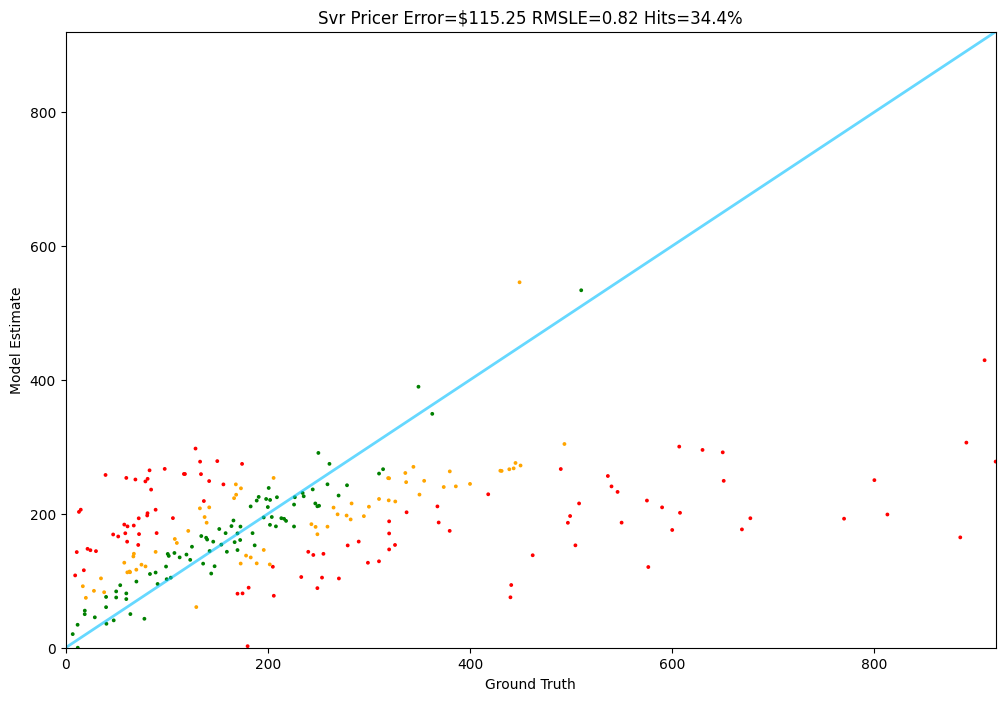

In [49]:
Tester.test(svr_pricer)

In [51]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

KeyboardInterrupt: 

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)